# Time Series Text Generation Dataset Builder

This notebook processes the original time series dataset to create a new dataset that includes text descriptions generated from the time series data. The text descriptions can be used for LLM-based forecasting tasks.

## Overview

1. Load the original time series dataset
2. Split the dataset into sequences of specified input length
3. Generate text descriptions for each sequence
4. Create a new dataset with both original data and generated text
5. Save the new dataset to a CSV file

## Parameters

- `input_len`: Length of input sequence to use for text generation
- `output_len`: Length of output sequence to predict


In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Add the project root to the path so we can import the utils module
sys.path.append('..')
from utils.text_generator import generate_prompt, batch_generate_prompts

# Set display options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


## 1. Load the Dataset


In [2]:
# Define the dataset path
dataset_path = os.path.join('..', 'dataset', 'data-com-latest-modified.csv')

# Load the dataset
df = pd.read_csv(dataset_path)

# Display basic information about the dataset
print(f"Dataset loaded successfully with {len(df)} rows and {len(df.columns)} columns")
print(f"Columns: {', '.join(df.columns)}")
print(f"First few rows:")
df.head()


Dataset loaded successfully with 8474 rows and 10 columns
Columns: CO2, Temperature, Humidity, Sun1, Sun2, Sun3, Sun4, Sun5, Sun6, date
First few rows:


,CO2,Temperature,Humidity,Sun1,Sun2,Sun3,Sun4,Sun5,Sun6,date
0,473.0,25.2,45.1,77.3,86.7,115.6,103.0,110.1,98.3,2025-04-26 16:53:56
1,465.0,25.3,42.1,77.5,84.1,120.1,101.0,109.3,97.7,2025-04-26 16:58:56
2,499.0,25.1,40.5,77.2,84.4,119.9,100.8,109.2,97.9,2025-04-26 17:03:56
3,536.0,24.9,40.7,78.3,82.9,119.7,102.2,110.0,97.5,2025-04-26 17:08:56
4,530.0,24.8,40.4,79.3,84.5,115.4,105.6,111.2,97.8,2025-04-26 17:13:56


## 2. Define Parameters

Set the input length and output length for the sequences.


In [3]:
# Define parameters
input_len = 96  # Length of input sequence
output_len = 96  # Length of output sequence to predict

# Variables to include in the dataset
variables = ['CO2', 'Temperature', 'Humidity', 'Sun1', 'Sun2', 'Sun3', 'Sun4', 'Sun5', 'Sun6']

print(f"Input length: {input_len}")
print(f"Output length: {output_len}")
print(f"Variables: {', '.join(variables)}")


Input length: 96
Output length: 96
Variables: CO2, Temperature, Humidity, Sun1, Sun2, Sun3, Sun4, Sun5, Sun6


## 3. Preprocess the Dataset

Handle missing values and prepare the dataset for processing.


In [4]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Handle missing values (if any)
df_clean = df.copy()
if df.isnull().values.any():
    print("\nFilling missing values...")
    df_clean = df.fillna(method='ffill').fillna(method='bfill')
    print("Missing values after filling:")
    print(df_clean.isnull().sum())

# Handle extreme values (e.g., 3999.9 in Sun columns)
for col in variables:
    if 'Sun' in col:
        # Replace extreme values with NaN and then fill
        mask = df_clean[col] > 1000
        if mask.any():
            print(f"Replacing extreme values in {col}...")
            df_clean.loc[mask, col] = np.nan
            df_clean[col] = df_clean[col].fillna(method='ffill').fillna(method='bfill')

# Display a sample of the cleaned data
print("\nSample of cleaned data:")
df_clean[variables].head()


Missing values in each column:
CO2            0
Temperature    0
Humidity       0
Sun1           0
Sun2           0
Sun3           0
Sun4           0
Sun5           0
Sun6           0
date           0
dtype: int64
Replacing extreme values in Sun1...
Replacing extreme values in Sun2...
Replacing extreme values in Sun3...
Replacing extreme values in Sun5...

Sample of cleaned data:


,CO2,Temperature,Humidity,Sun1,Sun2,Sun3,Sun4,Sun5,Sun6
0,473.0,25.2,45.1,77.3,86.7,115.6,103.0,110.1,98.3
1,465.0,25.3,42.1,77.5,84.1,120.1,101.0,109.3,97.7
2,499.0,25.1,40.5,77.2,84.4,119.9,100.8,109.2,97.9
3,536.0,24.9,40.7,78.3,82.9,119.7,102.2,110.0,97.5
4,530.0,24.8,40.4,79.3,84.5,115.4,105.6,111.2,97.8


## 4. Create Sequences and Generate Text

Split the dataset into sequences and generate text descriptions for each sequence.


In [5]:
def create_sequences(df, input_len, output_len, variables):
    """
    Create sequences from the dataset and generate text descriptions.
    
    Args:
        df (pandas.DataFrame): The dataset
        input_len (int): Length of input sequence
        output_len (int): Length of output sequence
        variables (list): List of variable names
        
    Returns:
        pandas.DataFrame: DataFrame with sequences and text descriptions
    """
    sequences = []
    
    # Calculate the number of sequences
    n_sequences = len(df) - input_len - output_len + 1
    
    for i in range(0, n_sequences):
        # Get input sequence
        input_seq = df.iloc[i:i+input_len]
        
        # Get output sequence (for reference)
        output_seq = df.iloc[i+input_len:i+input_len+output_len]
        
        # Generate text descriptions for each variable
        for var in variables:
            # Generate text for the current variable
            text = generate_prompt(input_seq[var].values, variable_name=var, n_forecast=output_len)
            
            # Store sequence information
            seq_info = {
                'sequence_id': i,
                'variable': var,
                'start_index': i,
                'end_index': i + input_len - 1,
                'text_description': text,
                'input_values': input_seq[var].values.tolist(),
                'output_values': output_seq[var].values.tolist() if len(output_seq) > 0 else []
            }
            
            sequences.append(seq_info)
    
    # Convert to DataFrame
    sequences_df = pd.DataFrame(sequences)
    return sequences_df

# Create sequences and generate text
print(f"Creating sequences with input_len={input_len} and output_len={output_len}...")
sequences_df = create_sequences(df_clean, input_len, output_len, variables)

# Display information about the sequences
print(f"Created {len(sequences_df)} sequences")
print(f"Number of unique sequence IDs: {sequences_df['sequence_id'].nunique()}")
print(f"Number of variables per sequence: {sequences_df['variable'].nunique()}")

# Display a sample sequence
print("\nSample sequence:")
sample = sequences_df.iloc[0]
print(f"Sequence ID: {sample['sequence_id']}")
print(f"Variable: {sample['variable']}")
print(f"Text Description:\n{sample['text_description']}")


Creating sequences with input_len=96 and output_len=96...
Created 74547 sequences
Number of unique sequence IDs: 8283
Number of variables per sequence: 9

Sample sequence:
Sequence ID: 0
Variable: CO2
Text Description:
The following is a time series of CO2 measured at regular intervals:
[473.0, 465.0, 499.0, 536.0, 530.0, 506.0, 481.0, 458.0, 478.0, 520.0, ...466.0, 467.0, 467.0, 466.0, 466.0, 471.0, 474.0, 476.0, 471.0, 474.0]

Statistical summary:
- Mean: 443.52
- Standard deviation: 32.34
- Minimum: 394.00
- Maximum: 537.00
- Trend: increasing
- Seasonality: no clear seasonality

Based on the above data and its statistical characteristics, forecast the next 96 values.


In [6]:
sequences_df

,sequence_id,variable,start_index,end_index,text_description,input_values,output_values
0,0,CO2,0,95,The following is a time series of CO2 measured...,"[473.0, 465.0, 499.0, 536.0, 530.0, 506.0, 481...","[475.0, 479.0, 481.0, 479.0, 481.0, 482.0, 479..."
1,0,Temperature,0,95,The following is a time series of Temperature ...,"[25.2, 25.3, 25.1, 24.9, 24.8, 24.9, 24.8, 24....","[16.9, 16.8, 16.7, 16.7, 16.6, 16.5, 16.5, 16...."
2,0,Humidity,0,95,The following is a time series of Humidity mea...,"[45.1, 42.1, 40.5, 40.7, 40.4, 40.2, 40.7, 41....","[83.2, 83.3, 83.8, 83.9, 84.2, 84.6, 84.7, 85...."
3,0,Sun1,0,95,The following is a time series of Sun1 measure...,"[77.3, 77.5, 77.2, 78.3, 79.3, 76.5, 79.1, 76....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,Sun2,0,95,The following is a time series of Sun2 measure...,"[86.7, 84.1, 84.4, 82.9, 84.5, 85.6, 82.8, 85....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...
74542,8282,Sun2,8282,8377,The following is a time series of Sun2 measure...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
74543,8282,Sun3,8282,8377,The following is a time series of Sun3 measure...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
74544,8282,Sun4,8282,8377,The following is a time series of Sun4 measure...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
74545,8282,Sun5,8282,8377,The following is a time series of Sun5 measure...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## 5. Visualize a Sample Sequence

Plot a sample sequence to visualize the input and output.


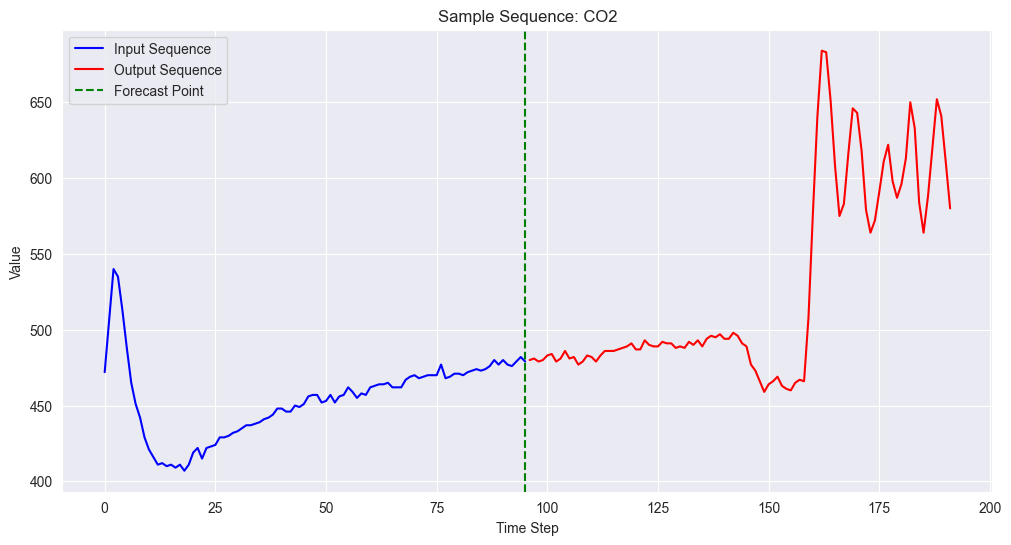

Text Description for CO2:
The following is a time series of CO2 measured at regular intervals:
[472.0, 506.0, 540.0, 535.0, 513.0, 488.0, 465.0, 451.0, 442.0, 429.0, ...474.0, 476.0, 480.0, 477.0, 480.0, 477.0, 476.0, 479.0, 482.0, 479.0]

Statistical summary:
- Mean: 454.50
- Standard deviation: 25.73
- Minimum: 407.00
- Maximum: 540.00
- Trend: increasing
- Seasonality: no clear seasonality

Based on the above data and its statistical characteristics, forecast the next 96 values.


In [7]:
# Select a sample sequence for visualization
sample_seq_id = 300
sample_var = 'CO2'

# Get the sample sequence
sample_seq = sequences_df[(sequences_df['sequence_id'] == sample_seq_id) & 
                          (sequences_df['variable'] == sample_var)].iloc[0]

# Plot the sequence
plt.figure(figsize=(12, 6))
plt.plot(range(input_len), sample_seq['input_values'], 'b-', label='Input Sequence')
if len(sample_seq['output_values']) > 0:
    plt.plot(range(input_len, input_len + len(sample_seq['output_values'])), 
             sample_seq['output_values'], 'r-', label='Output Sequence')
plt.axvline(x=input_len-1, color='g', linestyle='--', label='Forecast Point')
plt.title(f'Sample Sequence: {sample_var}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Display the text description
print(f"Text Description for {sample_var}:")
print(sample_seq['text_description'])


## 6. Save the Dataset

Save the sequences and text descriptions to a CSV file.


In [8]:
# Define the output path
output_dir = os.path.join('..', 'dataset')
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, f'text_dataset_in{input_len}_out{output_len}.csv')

# Save the dataset
print(f"Saving dataset to {output_path}...")
sequences_df.to_csv(output_path, index=False)
print("Dataset saved successfully!")

# Display the structure of the saved dataset
print("\nStructure of the saved dataset:")
print(sequences_df.columns.tolist())
print(f"\nTotal rows: {len(sequences_df)}")
print(f"Total unique sequences: {sequences_df['sequence_id'].nunique()}")


Saving dataset to ..\dataset\text_dataset_in96_out96.csv...
Dataset saved successfully!

Structure of the saved dataset:
['sequence_id', 'variable', 'start_index', 'end_index', 'text_description', 'input_values', 'output_values']

Total rows: 74547
Total unique sequences: 8283


## 7. Create a Compact Version of the Dataset

Create a more compact version of the dataset with just the essential information.


In [9]:
# Create a more compact version of the dataset
compact_df = sequences_df[['sequence_id', 'variable', 'text_description']].copy()

# Save the compact dataset
compact_output_path = os.path.join(output_dir, f'text_dataset_compact_in{input_len}_out{output_len}.csv')
print(f"Saving compact dataset to {compact_output_path}...")
compact_df.to_csv(compact_output_path, index=False)
print("Compact dataset saved successfully!")

# Display a sample of the compact dataset
print("\nSample of the compact dataset:")
compact_df.head()


Saving compact dataset to ..\dataset\text_dataset_compact_in96_out96.csv...
Compact dataset saved successfully!

Sample of the compact dataset:


,sequence_id,variable,text_description
0,0,CO2,The following is a time series of CO2 measured...
1,0,Temperature,The following is a time series of Temperature ...
2,0,Humidity,The following is a time series of Humidity mea...
3,0,Sun1,The following is a time series of Sun1 measure...
4,0,Sun2,The following is a time series of Sun2 measure...


## 8. Example: How to Use the Generated Dataset with an LLM

This section provides an example of how to use the generated dataset with an LLM for forecasting.


In [19]:
# Example code for using the dataset with an LLM (pseudocode)
print("Example: Using the generated dataset with an LLM (pseudocode)")
print("""
# 1. Load the dataset
text_dataset = pd.read_csv('dataset/text_dataset_compact_in96_out96.csv')

# 2. Select a sequence and variable
sequence_id = 0
variable = 'CO2'
prompt = text_dataset[(text_dataset['sequence_id'] == sequence_id) & 
                      (text_dataset['variable'] == variable)]['text_description'].values[0]

# 3. Send the prompt to an LLM
llm_response = call_llm_api(prompt)  # Replace with actual LLM API call

# 4. Parse the response to extract forecasted values
forecasted_values = parse_llm_response(llm_response)  # Implement parsing logic

# 5. Use the forecasted values
print(f"Forecasted values: {forecasted_values}")
""")


Example: Using the generated dataset with an LLM (pseudocode)

# 1. Load the dataset
text_dataset = pd.read_csv('dataset/text_dataset_compact_in96_out96.csv')

# 2. Select a sequence and variable
sequence_id = 0
variable = 'CO2'
prompt = text_dataset[(text_dataset['sequence_id'] == sequence_id) & 
                      (text_dataset['variable'] == variable)]['text_description'].values[0]

# 3. Send the prompt to an LLM
llm_response = call_llm_api(prompt)  # Replace with actual LLM API call

# 4. Parse the response to extract forecasted values
forecasted_values = parse_llm_response(llm_response)  # Implement parsing logic

# 5. Use the forecasted values
print(f"Forecasted values: {forecasted_values}")



## 9. Summary

This notebook has demonstrated how to:

1. Load and preprocess a time series dataset
2. Create sequences of specified input and output lengths
3. Generate text descriptions for each sequence
4. Save the generated dataset to CSV files
5. Provide an example of how to use the dataset with an LLM

The generated dataset can be used for LLM-based forecasting tasks, where the LLM is provided with the text description of a time series and asked to forecast future values.